In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [5]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [6]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [7]:



# Create a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # When using fancy indexing on a memmap, a copy is made only for this batch.
        return self.memmap_array[batch_idx]

# --- Data Loading Without Loading Entire Dataset Into RAM ---

# Load the dataset with memory mapping so that the full array isn’t loaded into RAM immediately.
save_path = "E:/dataset_1/preprocessed_sad.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path, mmap_mode='r')  # memmap; data remains on disk until accessed
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Use StratifiedShuffleSplit to get train/test indices without forcing a full copy.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(x_data, y_data))

# Sorting indices can help get more contiguous slices.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

# Instead of slicing x_data (which would copy a 12GB block into memory),
# create Sequences that load data in batches.
batch_size = 32
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is small so we load it normally.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test: {y_test.shape}")

# --- Training the Model ---
# Now call your train_model function as before—but pass the Sequence objects instead of full numpy arrays.
# For example:
#
# spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))
# train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test)
#
# Keras model.predict (and model.fit, if needed) supports Sequence objects, so your existing
# build_model() and train_model() functions remain unchanged.


📂 Loading precomputed dataset from E:/dataset_1/preprocessed_sad.npz...
✅ Loaded dataset: 20000 samples.
📊 Train/Test Split:
  x_train_seq: 500 batches (batch_size=32), y_train: (16000,)
  x_test_seq: 125 batches (batch_size=32), y_test: (4000,)


In [8]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(



Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1756s 4s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5067 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.5067 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5565 - loss: 0.6913
Epoch 2: val_accuracy improved from 0.50000 to 0.87150, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5567 - loss: 0.6912 - val_accuracy: 0.8715 - val_loss: 0.6845 - learning_rate: 1.0000e-04
Epoch 3/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6615 - loss: 0.6780
Epoch 3: val_accuracy did not improve from 0.87150
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6616 - loss: 0.6780 - val_accuracy: 0.5000 - val_loss: 0.6484 - learning_rate: 1.0000e-04
Epoch 4/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7485 - loss: 0.6104
Epoch 4: val_accuracy did not improve from 0.87150
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7487 - loss: 0.6101 - val_accuracy: 0.4997 - val_loss: 0.6378 - learning_rate: 1.0000e-04
Epoch 5/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8329 - loss: 0.4557
Epoch 5: val_accuracy did not improve from 0.87150
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8330 - loss: 0.4555 - val_accuracy: 0.8240 - val_loss: 0.3947 - learning_rate: 1.0000e-04

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8560 - loss: 0.3311 - val_accuracy: 0.8777 - val_loss: 0.2862 - learning_rate: 1.0000e-04
Epoch 8/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8656 - loss: 0.3153
Epoch 8: val_accuracy did not improve from 0.87775
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8656 - loss: 0.3152 - val_accuracy: 0.8752 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 9/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8645 - loss: 0.3129
Epoch 9: val_accuracy did not improve from 0.87775
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8646 - loss: 0.3129 - val_accuracy: 0.8763 - val_loss: 0.2790 - learning_rate: 1.0000e-04
Epoch 10/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8674 - loss: 0.3121
Epoch 10: val_accuracy improved from 0.87775 to 0.87800, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8674 - loss: 0.3121 - val_accuracy: 0.8780 - val_loss: 0.2826 - learning_rate: 1.0000e-04
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8700 - loss: 0.3122
Epoch 11: val_accuracy improved from 0.87800 to 0.87900, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8700 - loss: 0.3122 - val_accuracy: 0.8790 - val_loss: 0.2866 - learning_rate: 1.0000e-04
Epoch 12/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8687 - loss: 0.3041
Epoch 12: val_accuracy improved from 0.87900 to 0.87950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8687 - loss: 0.3042 - val_accuracy: 0.8795 - val_loss: 0.2786 - learning_rate: 1.0000e-04
Epoch 13/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8740 - loss: 0.3018
Epoch 13: val_accuracy did not improve from 0.87950
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8740 - loss: 0.3018 - val_accuracy: 0.8730 - val_loss: 0.3004 - learning_rate: 1.0000e-04
Epoch 14/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8735 - loss: 0.2999
Epoch 14: val_accuracy did not improve from 0.87950
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8735 - loss: 0.2999 - val_accuracy: 0.8792 - val_loss: 0.2803 - learning_rate: 1.0000e-04
Epoch 15/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8664 - loss: 0.3001
Epoch 15: val_accuracy improved from 0.87950 to 0.88400, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8665 - loss: 0.3001 - val_accuracy: 0.8840 - val_loss: 0.2709 - learning_rate: 1.0000e-04
Epoch 16/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8695 - loss: 0.2974
Epoch 16: val_accuracy did not improve from 0.88400
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8695 - loss: 0.2974 - val_accuracy: 0.8835 - val_loss: 0.2730 - learning_rate: 1.0000e-04
Epoch 17/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8764 - loss: 0.2876
Epoch 17: val_accuracy improved from 0.88400 to 0.88575, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8764 - loss: 0.2877 - val_accuracy: 0.8857 - val_loss: 0.2676 - learning_rate: 1.0000e-04
Epoch 18/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8789 - loss: 0.2907
Epoch 18: val_accuracy improved from 0.88575 to 0.88600, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8789 - loss: 0.2907 - val_accuracy: 0.8860 - val_loss: 0.2657 - learning_rate: 1.0000e-04
Epoch 19/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8758 - loss: 0.2907
Epoch 19: val_accuracy did not improve from 0.88600
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8758 - loss: 0.2907 - val_accuracy: 0.8840 - val_loss: 0.2702 - learning_rate: 1.0000e-04
Epoch 20/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8735 - loss: 0.2984
Epoch 20: val_accuracy did not improve from 0.88600
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8735 - loss: 0.2983 - val_accuracy: 0.8857 - val_loss: 0.2626 - learning_rate: 1.0000e-04
Epoch 21/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8721 - loss: 0.2984
Epoch 21: val_accuracy improved from 0.88600 to 0.88875, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8721 - loss: 0.2984 - val_accuracy: 0.8888 - val_loss: 0.2623 - learning_rate: 1.0000e-04
Epoch 22/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8752 - loss: 0.2893
Epoch 22: val_accuracy did not improve from 0.88875
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8752 - loss: 0.2893 - val_accuracy: 0.8795 - val_loss: 0.2910 - learning_rate: 1.0000e-04
Epoch 23/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8740 - loss: 0.2975
Epoch 23: val_accuracy improved from 0.88875 to 0.88925, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8740 - loss: 0.2975 - val_accuracy: 0.8892 - val_loss: 0.2611 - learning_rate: 1.0000e-04
Epoch 24/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8812 - loss: 0.2829
Epoch 24: val_accuracy did not improve from 0.88925
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8812 - loss: 0.2829 - val_accuracy: 0.8720 - val_loss: 0.2977 - learning_rate: 1.0000e-04
Epoch 25/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8819 - loss: 0.2841
Epoch 25: val_accuracy improved from 0.88925 to 0.88950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8819 - loss: 0.2841 - val_accuracy: 0.8895 - val_loss: 0.2600 - learning_rate: 1.0000e-04
Epoch 26/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8785 - loss: 0.2876
Epoch 26: val_accuracy improved from 0.88950 to 0.89125, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8785 - loss: 0.2876 - val_accuracy: 0.8913 - val_loss: 0.2600 - learning_rate: 1.0000e-04
Epoch 27/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8763 - loss: 0.2850
Epoch 27: val_accuracy improved from 0.89125 to 0.89175, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8763 - loss: 0.2850 - val_accuracy: 0.8917 - val_loss: 0.2548 - learning_rate: 1.0000e-04
Epoch 28/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8829 - loss: 0.2823
Epoch 28: val_accuracy improved from 0.89175 to 0.89525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8829 - loss: 0.2823 - val_accuracy: 0.8953 - val_loss: 0.2539 - learning_rate: 1.0000e-04
Epoch 29/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8800 - loss: 0.2883
Epoch 29: val_accuracy did not improve from 0.89525
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8800 - loss: 0.2883 - val_accuracy: 0.8932 - val_loss: 0.2515 - learning_rate: 1.0000e-04
Epoch 30/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8826 - loss: 0.2824
Epoch 30: val_accuracy improved from 0.89525 to 0.89550, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8826 - loss: 0.2824 - val_accuracy: 0.8955 - val_loss: 0.2501 - learning_rate: 1.0000e-04
Epoch 31/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8829 - loss: 0.2827
Epoch 31: val_accuracy did not improve from 0.89550
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8829 - loss: 0.2827 - val_accuracy: 0.8945 - val_loss: 0.2463 - learning_rate: 1.0000e-04
Epoch 32/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8820 - loss: 0.2809
Epoch 32: val_accuracy improved from 0.89550 to 0.89700, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8820 - loss: 0.2809 - val_accuracy: 0.8970 - val_loss: 0.2449 - learning_rate: 1.0000e-04
Epoch 33/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8826 - loss: 0.2858
Epoch 33: val_accuracy did not improve from 0.89700
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8826 - loss: 0.2857 - val_accuracy: 0.8915 - val_loss: 0.2631 - learning_rate: 1.0000e-04
Epoch 34/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8850 - loss: 0.2796
Epoch 34: val_accuracy did not improve from 0.89700
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8850 - loss: 0.2796 - val_accuracy: 0.8965 - val_loss: 0.2464 - learning_rate: 1.0000e-04
Epoch 35/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8853 - loss: 0.2718
Epoch 35: val_accuracy improved from 0.89700 to 0.89950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8853 - loss: 0.2718 - val_accuracy: 0.8995 - val_loss: 0.2406 - learning_rate: 1.0000e-04
Epoch 36/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8859 - loss: 0.2715
Epoch 36: val_accuracy did not improve from 0.89950
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8859 - loss: 0.2715 - val_accuracy: 0.8988 - val_loss: 0.2389 - learning_rate: 1.0000e-04
Epoch 37/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8856 - loss: 0.2713
Epoch 37: val_accuracy did not improve from 0.89950
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8856 - loss: 0.2713 - val_accuracy: 0.8992 - val_loss: 0.2404 - learning_rate: 1.0000e-04
Epoch 38/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8808 - loss: 0.2723
Epoch 38: val_accuracy did not improve from 0.89950
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8808 - loss: 0.2723 - val_accuracy: 0.8992 - val_loss: 0.2383 - learning_rate: 1.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8849 - loss: 0.2693 - val_accuracy: 0.9005 - val_loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 40/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8929 - loss: 0.2641
Epoch 40: val_accuracy improved from 0.90050 to 0.90525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8929 - loss: 0.2641 - val_accuracy: 0.9053 - val_loss: 0.2360 - learning_rate: 1.0000e-04
Epoch 41/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8897 - loss: 0.2677
Epoch 41: val_accuracy did not improve from 0.90525
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8898 - loss: 0.2677 - val_accuracy: 0.9030 - val_loss: 0.2326 - learning_rate: 1.0000e-04
Epoch 42/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8902 - loss: 0.2671
Epoch 42: val_accuracy improved from 0.90525 to 0.90750, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8902 - loss: 0.2671 - val_accuracy: 0.9075 - val_loss: 0.2319 - learning_rate: 1.0000e-04
Epoch 43/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8876 - loss: 0.2659
Epoch 43: val_accuracy did not improve from 0.90750
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8876 - loss: 0.2659 - val_accuracy: 0.9045 - val_loss: 0.2282 - learning_rate: 1.0000e-04
Epoch 44/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8886 - loss: 0.2760
Epoch 44: val_accuracy did not improve from 0.90750
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8886 - loss: 0.2760 - val_accuracy: 0.9040 - val_loss: 0.2341 - learning_rate: 1.0000e-04
Epoch 45/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8987 - loss: 0.2469
Epoch 45: val_accuracy did not improve from 0.90750
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8987 - loss: 0.2470 - val_accuracy: 0.8995 - val_loss: 0.2437 - learning_rate: 1.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8884 - loss: 0.2631 - val_accuracy: 0.9082 - val_loss: 0.2219 - learning_rate: 1.0000e-04
Epoch 48/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8989 - loss: 0.2527
Epoch 48: val_accuracy improved from 0.90825 to 0.91425, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8989 - loss: 0.2527 - val_accuracy: 0.9143 - val_loss: 0.2223 - learning_rate: 1.0000e-04
Epoch 49/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8981 - loss: 0.2451
Epoch 49: val_accuracy did not improve from 0.91425
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8981 - loss: 0.2451 - val_accuracy: 0.9125 - val_loss: 0.2181 - learning_rate: 1.0000e-04
Epoch 50/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9030 - loss: 0.2562
Epoch 50: val_accuracy did not improve from 0.91425
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9029 - loss: 0.2562 - val_accuracy: 0.9105 - val_loss: 0.2207 - learning_rate: 1.0000e-04
Epoch 51/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8960 - loss: 0.2519
Epoch 51: val_accuracy did not improve from 0.91425
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8960 - loss: 0.2519 - val_accuracy: 0.9030 - val_loss: 0.2365 - learning_rate: 1.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9041 - loss: 0.2366 - val_accuracy: 0.9178 - val_loss: 0.2099 - learning_rate: 1.0000e-04
Epoch 54/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9090 - loss: 0.2394
Epoch 54: val_accuracy improved from 0.91775 to 0.91975, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9089 - loss: 0.2394 - val_accuracy: 0.9197 - val_loss: 0.2112 - learning_rate: 1.0000e-04
Epoch 55/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9090 - loss: 0.2303
Epoch 55: val_accuracy did not improve from 0.91975
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9090 - loss: 0.2303 - val_accuracy: 0.9140 - val_loss: 0.2133 - learning_rate: 1.0000e-04
Epoch 56/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9050 - loss: 0.2360
Epoch 56: val_accuracy did not improve from 0.91975
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9050 - loss: 0.2360 - val_accuracy: 0.9143 - val_loss: 0.2134 - learning_rate: 1.0000e-04
Epoch 57/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9015 - loss: 0.2403
Epoch 57: val_accuracy did not improve from 0.91975
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9016 - loss: 0.2403 - val_accuracy: 0.9170 - val_loss: 0.2076 - learning_rate: 1.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9081 - loss: 0.2312 - val_accuracy: 0.9265 - val_loss: 0.1958 - learning_rate: 1.0000e-04
Epoch 61/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9053 - loss: 0.2339
Epoch 61: val_accuracy did not improve from 0.92650
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9053 - loss: 0.2339 - val_accuracy: 0.9200 - val_loss: 0.2005 - learning_rate: 1.0000e-04
Epoch 62/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9100 - loss: 0.2289
Epoch 62: val_accuracy improved from 0.92650 to 0.92950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9100 - loss: 0.2289 - val_accuracy: 0.9295 - val_loss: 0.1911 - learning_rate: 1.0000e-04
Epoch 63/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9084 - loss: 0.2294
Epoch 63: val_accuracy did not improve from 0.92950
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9085 - loss: 0.2294 - val_accuracy: 0.9137 - val_loss: 0.2152 - learning_rate: 1.0000e-04
Epoch 64/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9108 - loss: 0.2294
Epoch 64: val_accuracy did not improve from 0.92950
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9108 - loss: 0.2294 - val_accuracy: 0.9280 - val_loss: 0.1879 - learning_rate: 1.0000e-04
Epoch 65/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9080 - loss: 0.2294
Epoch 65: val_accuracy improved from 0.92950 to 0.93375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9080 - loss: 0.2294 - val_accuracy: 0.9337 - val_loss: 0.1847 - learning_rate: 1.0000e-04
Epoch 66/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9138 - loss: 0.2196
Epoch 66: val_accuracy did not improve from 0.93375
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9138 - loss: 0.2196 - val_accuracy: 0.9262 - val_loss: 0.1869 - learning_rate: 1.0000e-04
Epoch 67/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9151 - loss: 0.2198
Epoch 67: val_accuracy did not improve from 0.93375
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9151 - loss: 0.2198 - val_accuracy: 0.9330 - val_loss: 0.1815 - learning_rate: 1.0000e-04
Epoch 68/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9106 - loss: 0.2230
Epoch 68: val_accuracy improved from 0.93375 to 0.93550, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9106 - loss: 0.2230 - val_accuracy: 0.9355 - val_loss: 0.1789 - learning_rate: 1.0000e-04
Epoch 69/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9124 - loss: 0.2229
Epoch 69: val_accuracy improved from 0.93550 to 0.93775, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9124 - loss: 0.2229 - val_accuracy: 0.9377 - val_loss: 0.1770 - learning_rate: 1.0000e-04
Epoch 70/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9178 - loss: 0.2125
Epoch 70: val_accuracy improved from 0.93775 to 0.93825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9178 - loss: 0.2125 - val_accuracy: 0.9383 - val_loss: 0.1738 - learning_rate: 1.0000e-04
Epoch 71/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9163 - loss: 0.2163
Epoch 71: val_accuracy did not improve from 0.93825
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9163 - loss: 0.2163 - val_accuracy: 0.9325 - val_loss: 0.1761 - learning_rate: 1.0000e-04
Epoch 72/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9124 - loss: 0.2254
Epoch 72: val_accuracy improved from 0.93825 to 0.94125, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9124 - loss: 0.2254 - val_accuracy: 0.9413 - val_loss: 0.1700 - learning_rate: 1.0000e-04
Epoch 73/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9167 - loss: 0.2079
Epoch 73: val_accuracy did not improve from 0.94125
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9167 - loss: 0.2080 - val_accuracy: 0.9358 - val_loss: 0.1823 - learning_rate: 1.0000e-04
Epoch 74/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9178 - loss: 0.2079
Epoch 74: val_accuracy did not improve from 0.94125
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9177 - loss: 0.2080 - val_accuracy: 0.9380 - val_loss: 0.1798 - learning_rate: 1.0000e-04
Epoch 75/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9187 - loss: 0.2144
Epoch 75: val_accuracy improved from 0.94125 to 0.94475, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9187 - loss: 0.2144 - val_accuracy: 0.9448 - val_loss: 0.1648 - learning_rate: 1.0000e-04
Epoch 76/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9163 - loss: 0.2125
Epoch 76: val_accuracy did not improve from 0.94475
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9163 - loss: 0.2125 - val_accuracy: 0.9205 - val_loss: 0.2001 - learning_rate: 1.0000e-04
Epoch 77/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9208 - loss: 0.2059
Epoch 77: val_accuracy did not improve from 0.94475
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9208 - loss: 0.2059 - val_accuracy: 0.9308 - val_loss: 0.1719 - learning_rate: 1.0000e-04
Epoch 78/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9162 - loss: 0.2111
Epoch 78: val_accuracy did not improve from 0.94475
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9162 - loss: 0.2111 - val_accuracy: 0.9420 - val_loss: 0.1589 - learning_rate: 1.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9296 - loss: 0.1889 - val_accuracy: 0.9492 - val_loss: 0.1531 - learning_rate: 5.0000e-05
Epoch 84/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9298 - loss: 0.1918
Epoch 84: val_accuracy did not improve from 0.94925
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9297 - loss: 0.1918 - val_accuracy: 0.9342 - val_loss: 0.1658 - learning_rate: 5.0000e-05
Epoch 85/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9258 - loss: 0.1930
Epoch 85: val_accuracy did not improve from 0.94925
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9258 - loss: 0.1930 - val_accuracy: 0.9490 - val_loss: 0.1532 - learning_rate: 5.0000e-05
Epoch 86/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9285 - loss: 0.1839
Epoch 86: val_accuracy did not improve from 0.94925
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9285 - loss: 0.1840 - val_accuracy: 0.9480 - val_loss: 0.1501 - learning_rate: 5.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9316 - loss: 0.1834 - val_accuracy: 0.9498 - val_loss: 0.1539 - learning_rate: 5.0000e-05
Epoch 89/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9261 - loss: 0.1928
Epoch 89: val_accuracy did not improve from 0.94975
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9261 - loss: 0.1928 - val_accuracy: 0.9488 - val_loss: 0.1469 - learning_rate: 5.0000e-05
Epoch 90/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9324 - loss: 0.1764
Epoch 90: val_accuracy did not improve from 0.94975
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9324 - loss: 0.1764 - val_accuracy: 0.9442 - val_loss: 0.1466 - learning_rate: 5.0000e-05
Epoch 91/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9279 - loss: 0.1882
Epoch 91: val_accuracy improved from 0.94975 to 0.95150, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9279 - loss: 0.1881 - val_accuracy: 0.9515 - val_loss: 0.1421 - learning_rate: 5.0000e-05
Epoch 92/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9343 - loss: 0.1772
Epoch 92: val_accuracy did not improve from 0.95150
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9343 - loss: 0.1772 - val_accuracy: 0.9490 - val_loss: 0.1445 - learning_rate: 5.0000e-05
Epoch 93/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9321 - loss: 0.1755
Epoch 93: val_accuracy improved from 0.95150 to 0.95300, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9321 - loss: 0.1756 - val_accuracy: 0.9530 - val_loss: 0.1453 - learning_rate: 5.0000e-05
Epoch 94/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9390 - loss: 0.1737
Epoch 94: val_accuracy did not improve from 0.95300
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9390 - loss: 0.1738 - val_accuracy: 0.9480 - val_loss: 0.1411 - learning_rate: 5.0000e-05
Epoch 95/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9299 - loss: 0.1861
Epoch 95: val_accuracy did not improve from 0.95300
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9299 - loss: 0.1861 - val_accuracy: 0.9490 - val_loss: 0.1397 - learning_rate: 5.0000e-05
Epoch 96/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9299 - loss: 0.1859
Epoch 96: val_accuracy did not improve from 0.95300
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9299 - loss: 0.1859 - val_accuracy: 0.9520 - val_loss: 0.1378 - learning_rate: 5.00

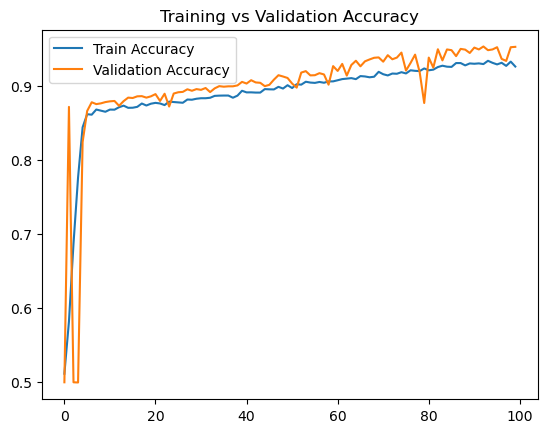

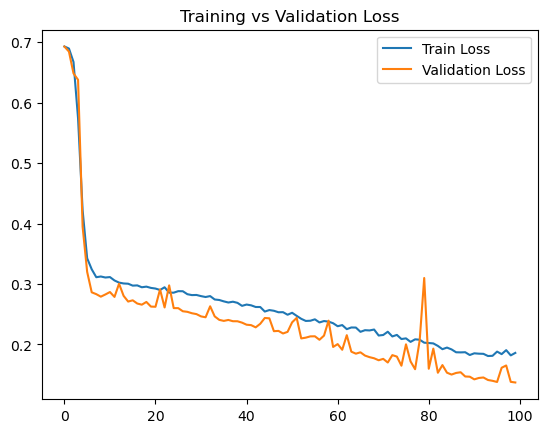

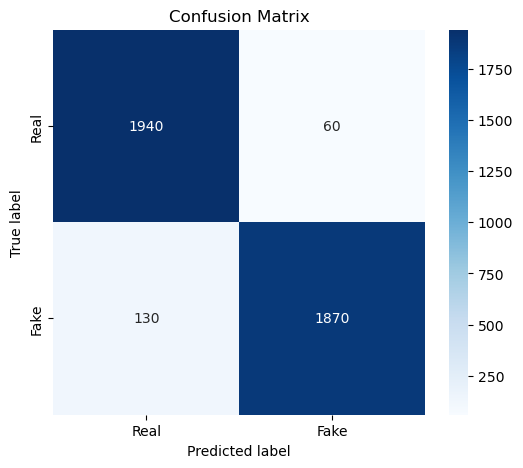

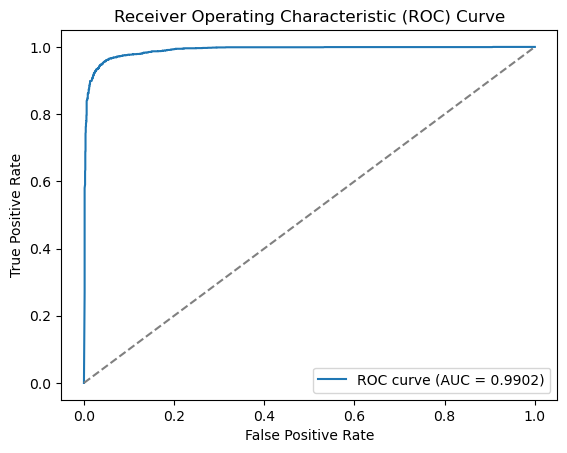

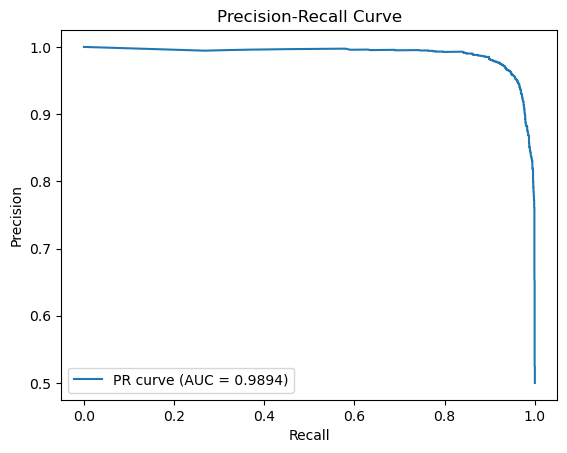

Accuracy Score: 0.9525
ROC AUC Score: 0.9902
Recall Score: 0.9350
Precision Score: 0.9689
F1 Score: 0.9517
PR AUC Score: 0.9894
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2000
           1       0.97      0.94      0.95      2000

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [9]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)